# Pasta Shape Recognizer
The goal of this project is to classify 20 different types of pasta shapes. The types are following:

1. Spaghetti
2. Fettuccine
3. Penne
4. Rigatoni
5. Fusilli
6. Farfalle
7. Linguine
8. Tagliatelle
9. Lasagna
10. Ravioli
11. Tortellini
12. Orecchiette
13. Conchiglie
14. Rotini
15. Bucatini
16. Cannelloni
17. Macaroni
18. Orzo
19. Cavatappi
20. Gemelli

## Setting Up Necessary Things

In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

## Fetch Data to Data Loaders
Set up a `DataBlock` that defines how to load, split, and preprocess the image data for training a machine learning model. It specifies that the data consists of images and their corresponding labels, splits the data into training and validation sets, and resizes the images to a fixed size.
- `blocks=(ImageBlock, CategoryBlock)`: Specifies that the data consists of images (handled by `ImageBlock`) and corresponding categories or labels (handled by `CategoryBlock`).

- `get_items=get_image_files`: Specifies the function to retrieve the list of image files. `get_image_files` is a built-in function in **Fastai** that recursively retrieves all image files in a given path.

- `splitter=RandomSplitter(valid_pct=0.1, seed=42)`: Defines the splitting strategy for the dataset. In this case, it uses `RandomSplitter` to randomly split the data into training and validation sets, with 10% of the data used for validation. The `seed` parameter ensures reproducibility of the split.

- `get_y=parent_label`: Specifies the function to extract the labels for each image. `parent_label` is a built-in function in **Fastai** that takes the parent folder name as the label for each image.

- `item_tfms=Resize(128)`: Applies image transformations to each item (image) in the dataset. Here, it resizes all images to a fixed size of 128x128 pixels to ensure consistent input shape for the model.

In [54]:
data_path = "../data"
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))                            # resizing to get the image of same shape

In [55]:
bs = 8 # batch size
version = 2 # update version on each iteration
dataloader_path = "../dataloaders/pasta_shape_dataloader"

For saving a new version of the dataloader:

In [56]:
block = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path, bs = bs)
torch.save(dls, f"{dataloader_path}_v{version}.pkl")

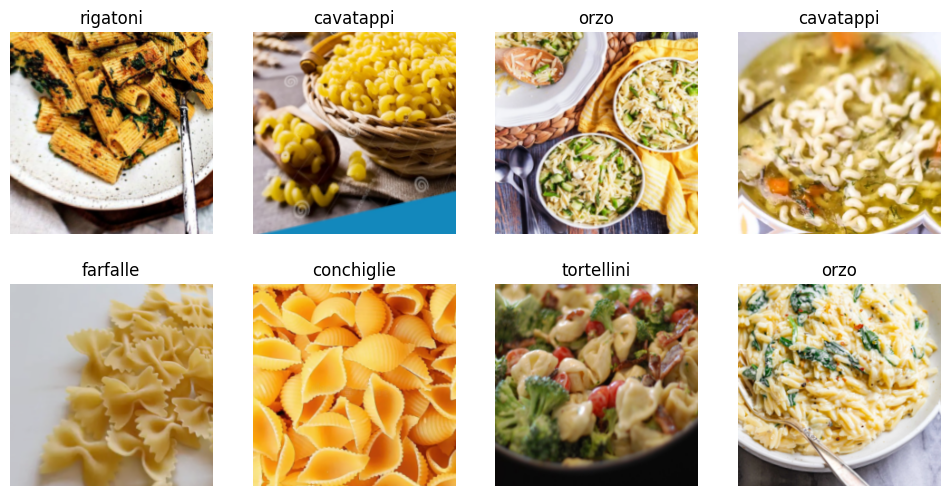

In [57]:
dls.train.show_batch(max_n=8, nrows=2)

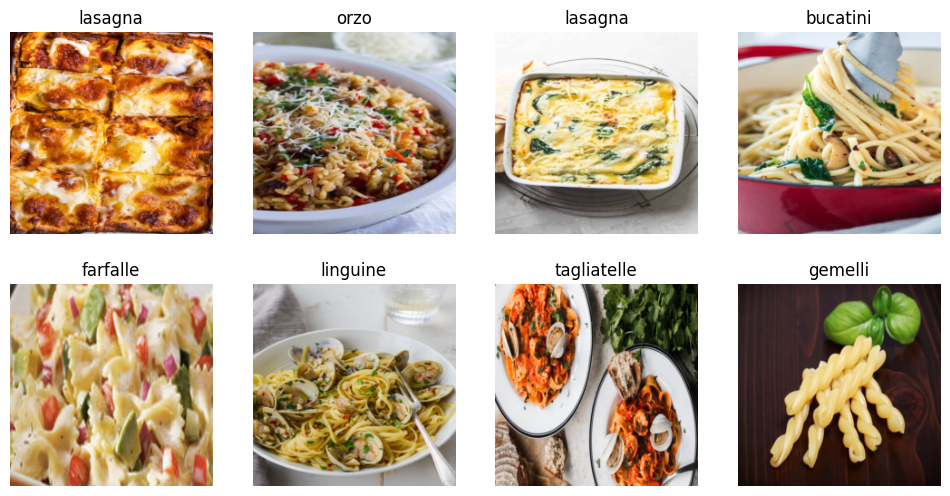

In [58]:
dls.valid.show_batch(max_n=8, nrows=2)

## Training and Data Cleaning
Create a vision learner model using the **Fastai** library and fine-tune it for image classification. Here's a breakdown of what each part does:

- `vision_learner(dls, resnet34, metrics=[error_rate,accuracy])`:
   - `dls`: The `DataLoaders` object that contains the preprocessed image data and labels.
   - `resnet34`: The architecture of the pre-trained model being used as the base model. In this case, it's using the ResNet34 model, which is a 34-layer residual neural network.
   - `metrics=[error_rate,accuracy]`: Specifies the evaluation metrics to be used during training. Here, it's using `error_rate` and `accuracy` as the metrics to monitor the model's performance.

   This line creates a `Learner` object (`model`) that wraps the ResNet34 model and is configured for vision tasks using the provided `DataLoaders` and evaluation metrics.

- `model.fine_tune(5)`:
   - `5`: The number of epochs to fine-tune the model.

   This line fine-tunes the pre-trained ResNet34 model using the specified `DataLoaders` for 5 epochs. Fine-tuning means that the model's weights are updated by training on the new dataset, starting from the pre-trained weights. This allows the model to adapt to the specific task and dataset while leveraging the knowledge learned from the pre-training.

During the fine-tuning process, the model will go through the training data for 5 epochs, updating its weights to minimize the loss function and improve its performance on the task of classifying the pasta shapes. The specified evaluation metrics (`error_rate` and `accuracy`) will be computed and reported during training to monitor the model's progress.

After fine-tuning, the `model` object will be updated with the fine-tuned weights and can be used for making predictions on new images or further evaluation.

In [59]:
model_path = "../models/pasta_shape_recognizer"

When training for first time, download and load a pre-trained vision model. (e.g. **ResNet34**)

In [60]:
model = vision_learner(dls, resnet34, metrics=[error_rate,accuracy])

When training for first time, we will fine-tune the model using 5 epochs:

In [11]:
model.fine_tune(5)

e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


After 5 epochs on ResNet34, we acieved `~75%` accuracy. We have to further train this model after data cleaning. Everytime after the end of training, we'll save the model state/progress as a checkpoint file (so that in case of a system failure we don't have to re-train the model from scratch). We'll load this checkpoint file again in next version and continue training from this point until we're satidfied with its performance.

In [12]:
model.save(f"pasta_shape_recognizer_v{version}")

Path('models/pasta_shape_recognizer_v0.pth')

For `version>0`: Load existing trained model checkpoints to train the model again with cleaned Dataset.

In [61]:
model.load(f"pasta_shape_recognizer_v{version-1}")

For `version=1`: While training a previously trained model we'll use 2 epochs (5 epochs already done before)

In [37]:
model.fine_tune(2)

e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


After 2 more epochs, we achieved an accuracy of `~79.5%`. We need to further train the model after data cleaning.

In [38]:
model.save(f"pasta_shape_recognizer_v{version}")

Path('models/pasta_shape_recognizer_v1.pth')

For `version=2`: This time we'll use 2 epochs (5+2 epochs already done before)

In [62]:
model.fine_tune(2)

e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


At this stage, we achieved an accuracy of `~85.6%` which good enough for our purpose.

In [63]:
model.save(f"pasta_shape_recognizer_v{version}")

Path('models/pasta_shape_recognizer_v2.pth')

Confusion matrix for `version=0`:

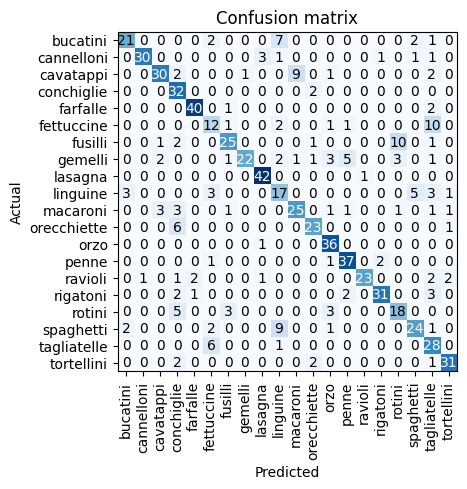

In [13]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

Confusion matrix for `version=1`:

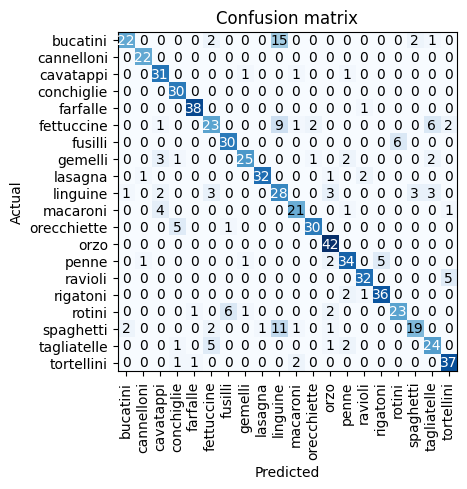

In [39]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

Confusion matrix for `version=2`:

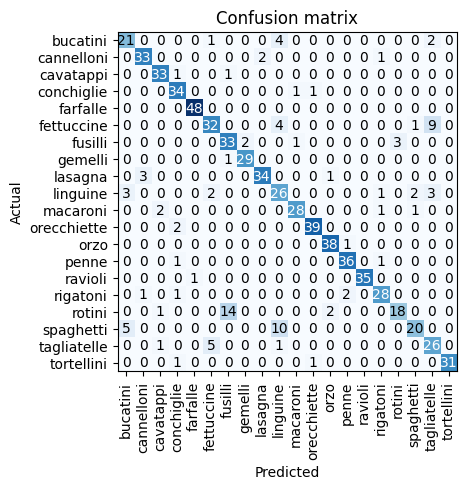

In [64]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

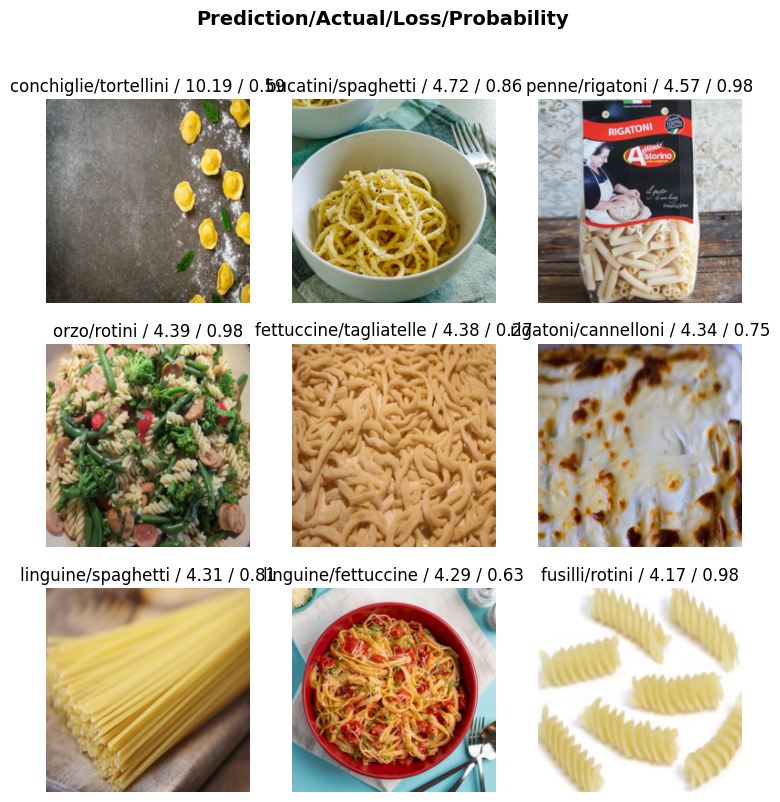

In [66]:
interp.plot_top_losses(9, nrows=3)

In [41]:
cleaner = ImageClassifierCleaner(model)
cleaner # (bucatini/linguine/sphagetti) (cavatappi/macaroni) (fettuccine/tagliatelle) (fusilli/rotini)

e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
e:\Data Science\Pasta-Shape-Recognizer\venv\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [52]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()                                    # delete irrelevant data
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), f"{data_path}/{cat}") # change the directory

## Export model for Inference

In [67]:
model.export(f"{model_path}_v{version}.pkl")